### Windfarms

Here are some examples of windfarms. The name of the files contain the ID of the windfarm. The ERA5 data was selected based on the location in this xls table

In [1]:
import pandas as pd
df = pd.read_excel("https://www.thewindpower.net/data/samples/Sample_World_Windfarms.xls", sheet_name="Windfarms", skiprows=[1])
df.pop("2nd name")
df.head()  # remove .head() to see the full table

,ID,Continent,ISO code,Country,State code,Area,City,Name,Latitude,Longitude,...,Number of turbines,Total power,Developer,Operator,Owner,Commissioning date,Status,Decommissioning date,Link,Update
0,27,Oceania,AU,Australia,QLD,Queensland,Ravenshoe,Windy Hill,-17.590006,145.531549,...,20,12000,Stanwell Corp,Stanwell Corp,Ratch Australia Corporation,2000/08,Production,NaN,Link,2022-10-25
1,13,Europe,BE,Belgium,#ND,Brabant wallon (Wallonie),Villers-la-Ville,Marbais,50.537381,4.514866,...,8,16000,Eneco,Electrastar SA,Eneco,2007,Production,NaN,Link,2022-10-20
2,12,Europe,BE,Belgium,#ND,Liège (Wallonie),Villers le Bouillet,Villers le Bouillet,50.580000,5.240000,...,6,9000,EDF renewables/Energie 2030,EDF renewables,EDF Luminus,2005/02,Production,NaN,Link,2022-05-20
3,16,Europe,BE,Belgium,#ND,Namur (Wallonie),Floreffe,Floreffe,50.422861,4.718278,...,1,2350,EDF Luminus,EDF Luminus,EDF Luminus,2010,Production,NaN,Link,2022-05-20
4,11,Europe,BE,Belgium,#ND,Namur (Wallonie),Walcourt,Tarcienne,50.302828,4.504480,...,6,9000,EDF renewables,EDF renewables,EDF Luminus,2005/11,Production,NaN,Link,2022-05-20


In [2]:
import xarray as xr
import glob
import os

basepath = "/shared1/ICS/LOT1/windpower/"
wfid_list = [
    14, 20, 27
]

# get file from ID
def get_file_from_id(wind_farm_id, basepath):
    files = glob.glob(os.path.join(basepath, "ID_{}_*.nc".format(wind_farm_id)))
    assert len(files) == 1 # make sure there is only one file
    return files[0]


# try with one ID
wind_farm_ds_dict = {
    wind_farm_id: xr.open_dataset(get_file_from_id(wind_farm_id, basepath)).ws100 for wind_farm_id in wfid_list
}

wind_farm_ds_dict[14]

<xarray.DataArray 'ws100' (time: 140256)>
[140256 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 ... 2005-12-31T23:00:00
    longitude  float32 ...
    latitude   float32 ...
Attributes:
    long_name:  100 metre wind speed
    units:      m s**-1

Next, give some parameters for the turbine at this location. 

In [3]:
import numpy as np
import power_curves as pc

# power_conversion_function_csv = pc.power_curve_from_csv("https://www.thewindpower.net/data/samples/Sample_Power_curves.xls", "MM82", "Turbine Name")

power_conversion_function_parameters = [
    {"Pnom": 2000, "Drotor": 80},
    {"Pnom": 2000, "Drotor": 85},
    {"Pnom": 3000, "Drotor": 80},
]

labels = ["Pnom: {Pnom} kW, Drotor: {Drotor} m".format(**kwargs) for kwargs in power_conversion_function_parameters]

power_conversion_functions = [pc.power_curve_from_parameters(wind_speed_resolution=0.5, **kwargs) for kwargs in power_conversion_function_parameters]

power_da_list_collection = {
    wind_farm_id: [power_conversion_function(da) for power_conversion_function in power_conversion_functions] 
    for wind_farm_id, da in wind_farm_ds_dict.items()
}

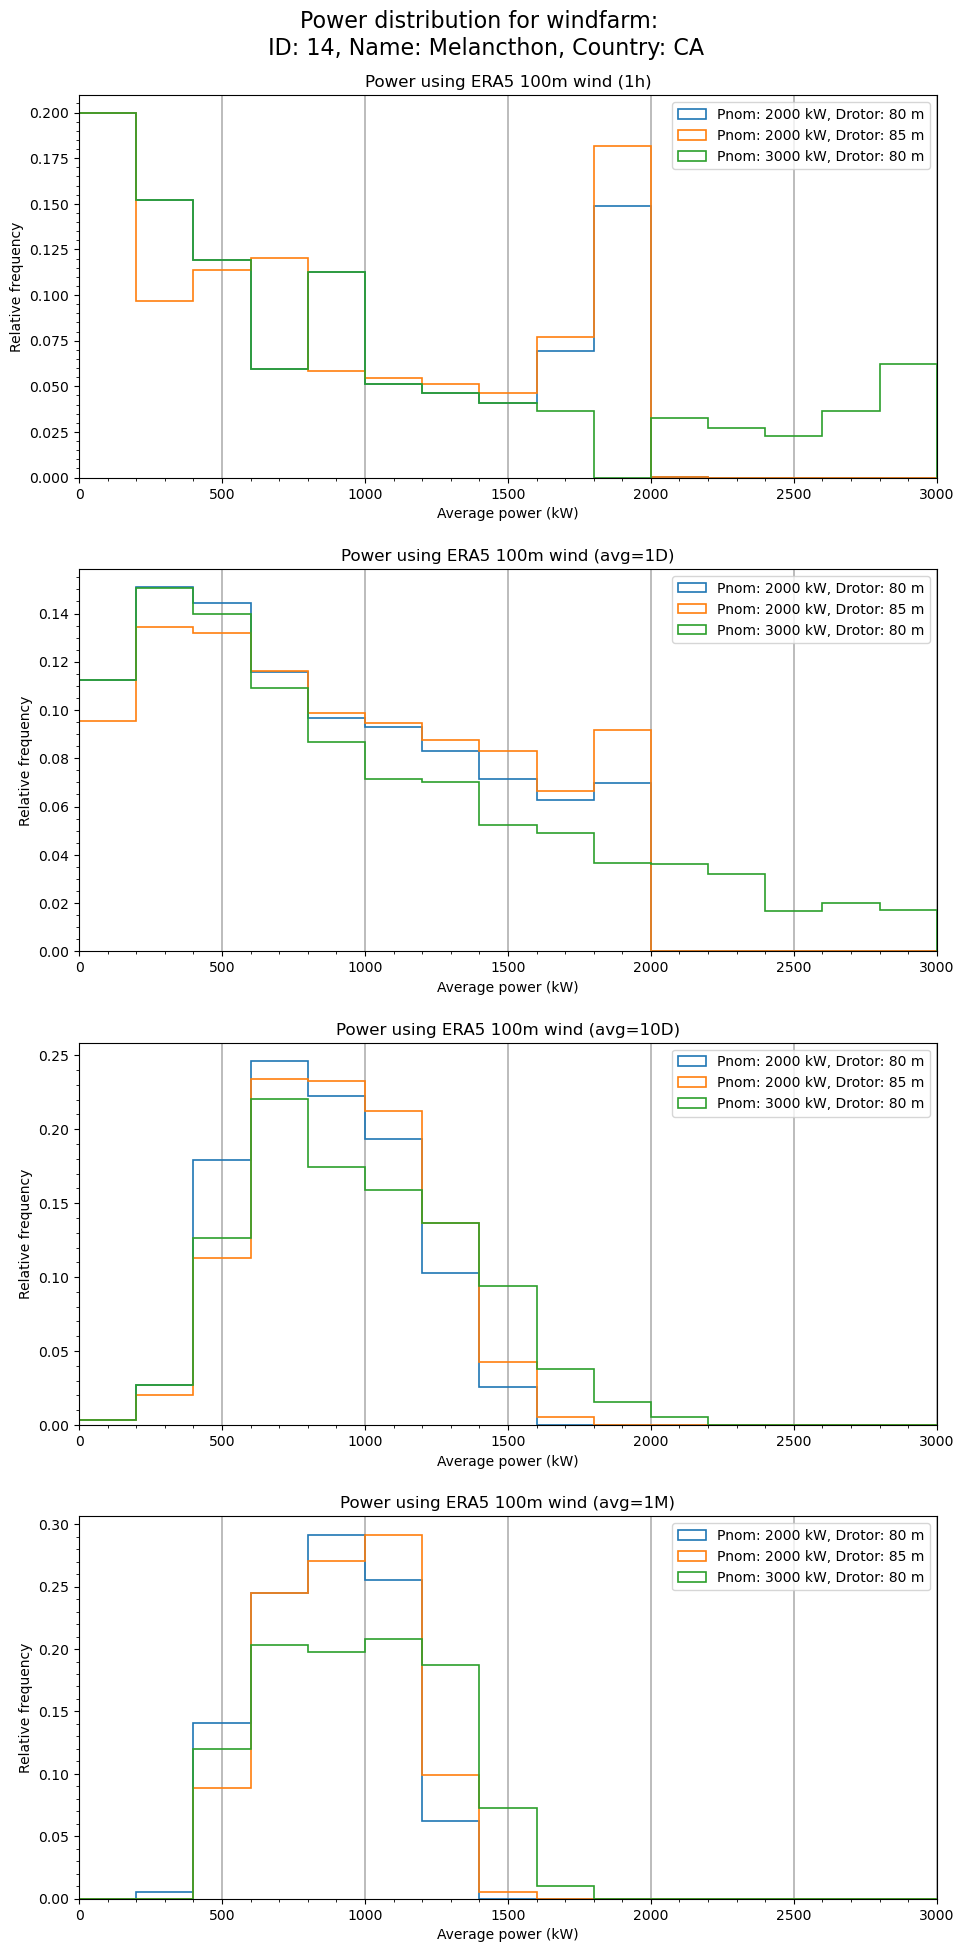

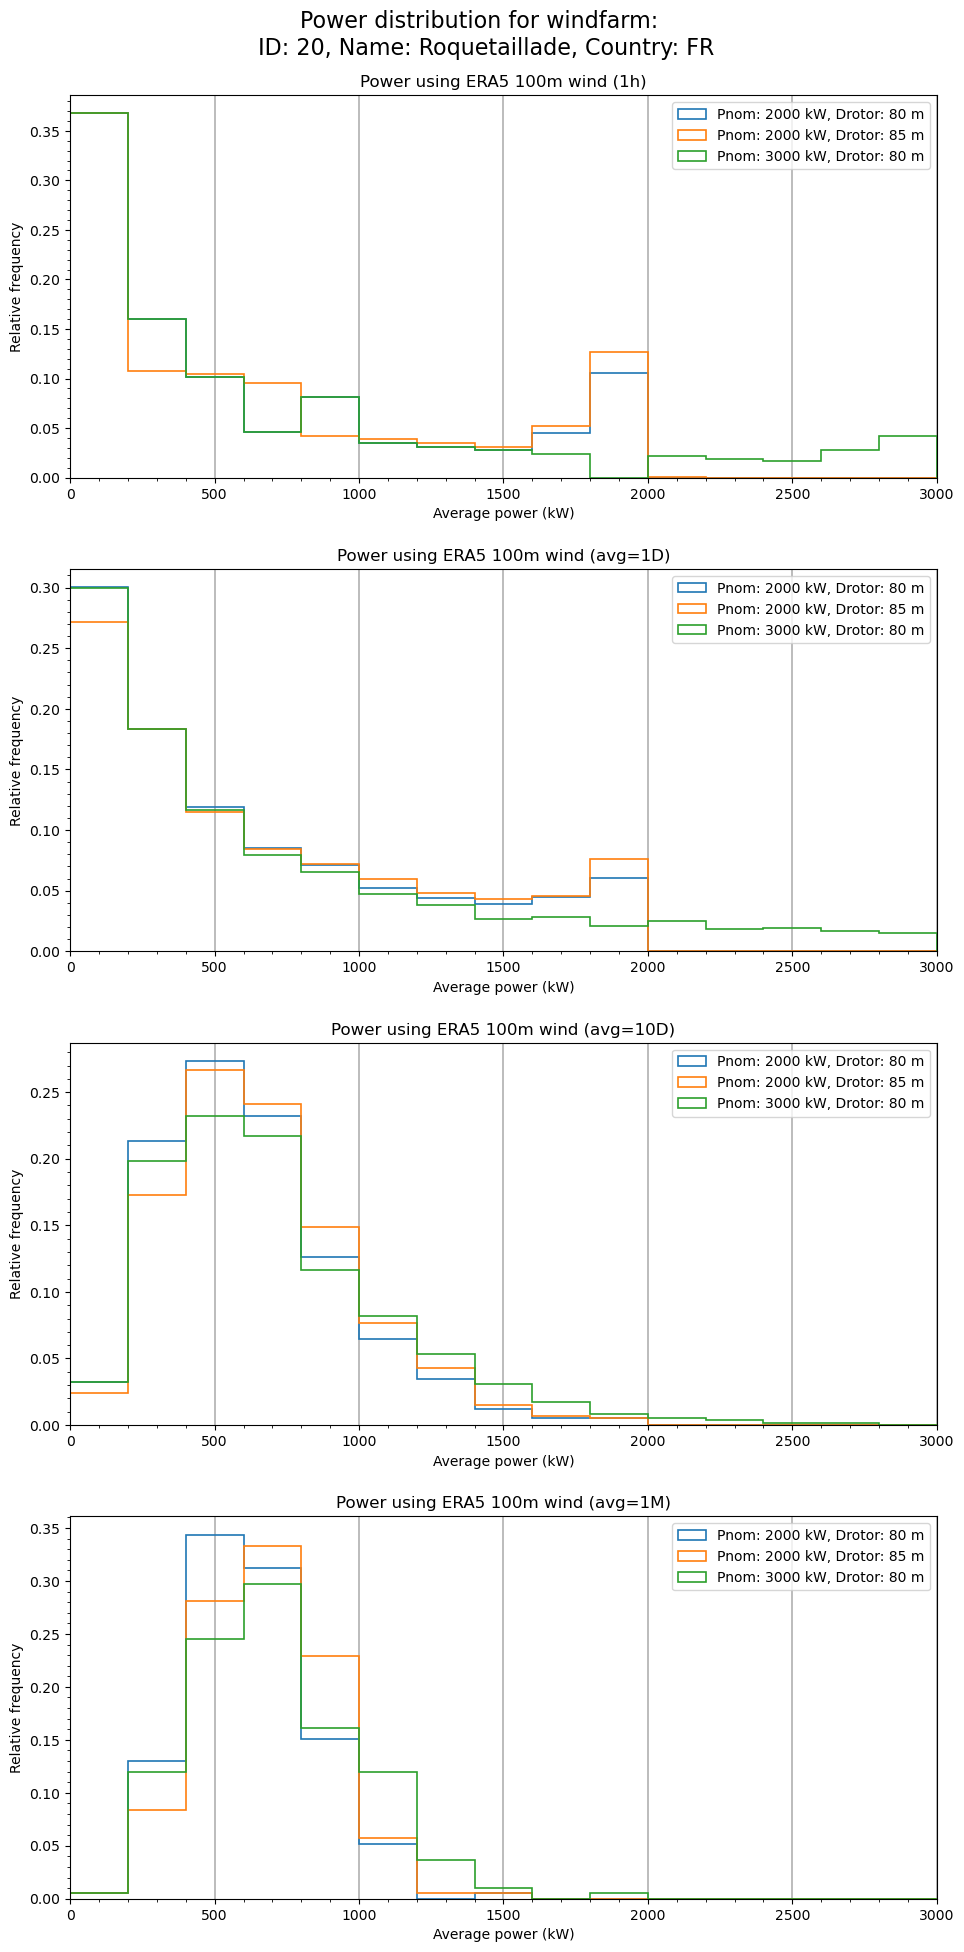

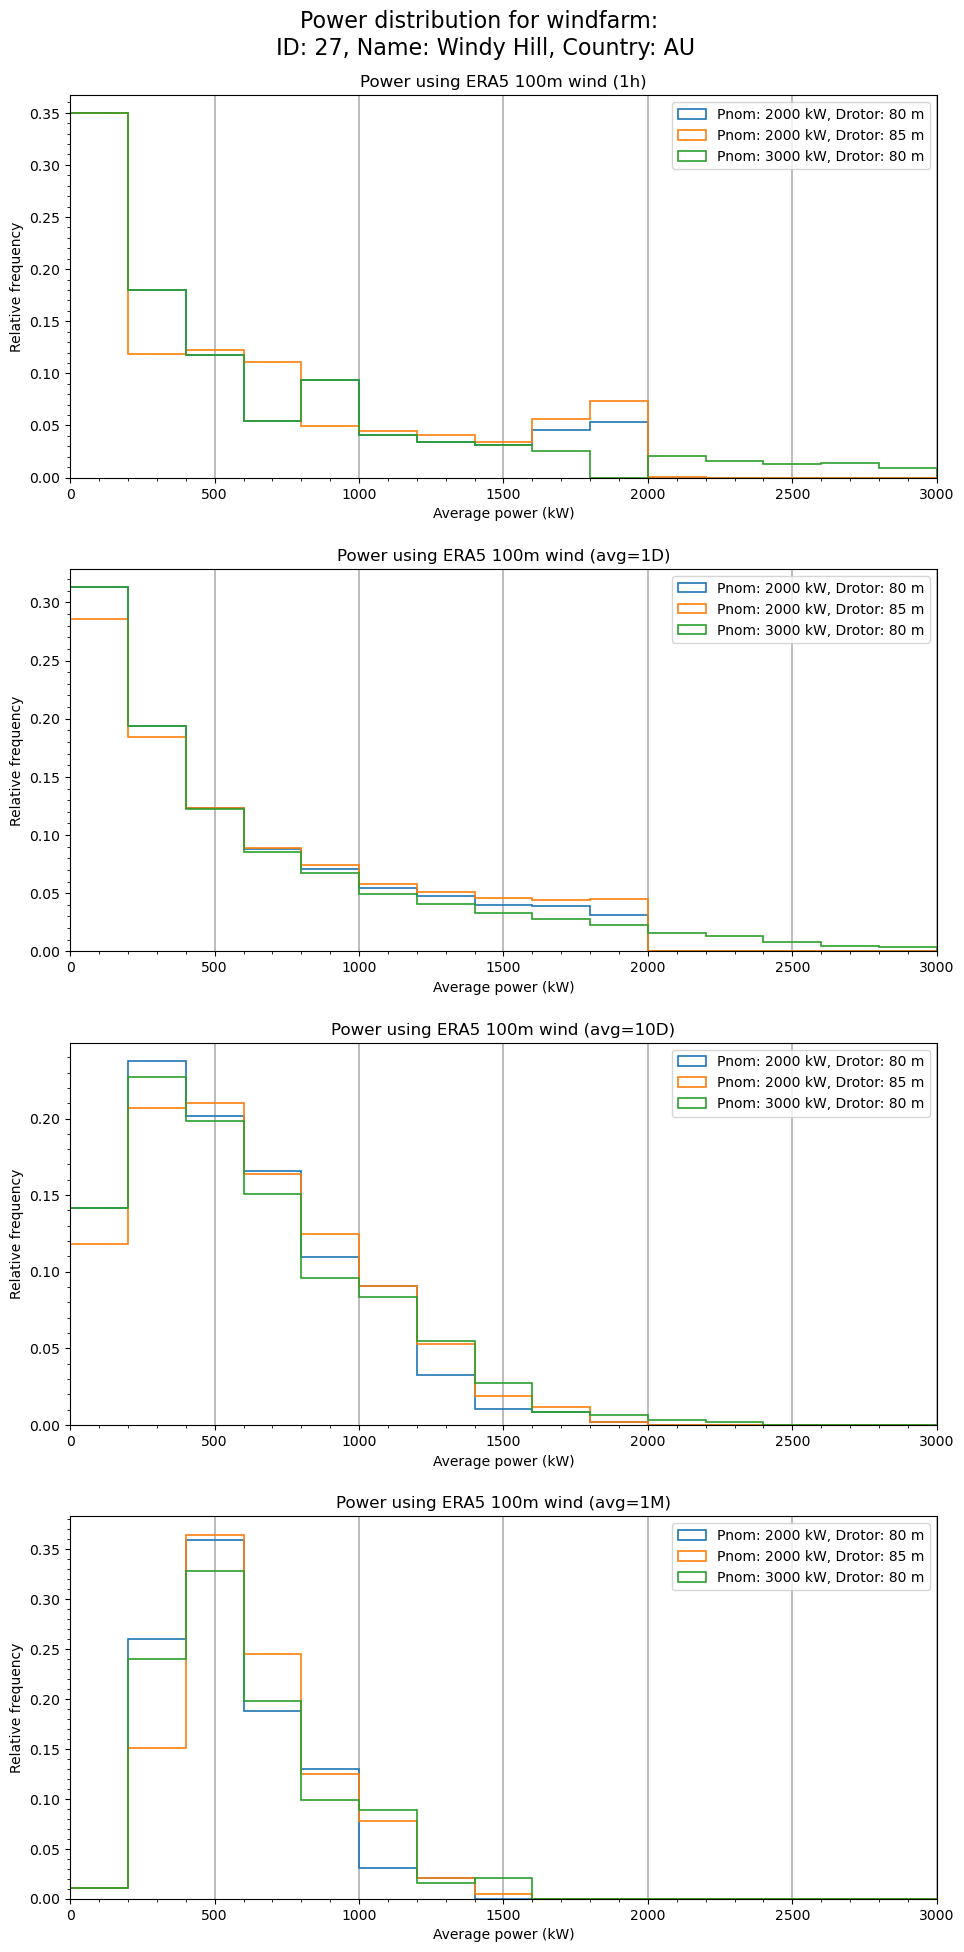

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import itertools

# histograms from power_da_list
def histograms_from_power_da_list(power_da_list, wind_farm_id, labels):

    bins = np.arange(0, 3200, 200)

    fig, axs = plt.subplots(4, 1, figsize=(10, 20))

    resampling_frequencies = [None, "1D", "10D", "1M"]

    for i, freq in enumerate(resampling_frequencies):

        colors = itertools.cycle(plt.get_cmap("tab10").colors)

        if freq is not None:
            power_da_resampled_list = [power_da.resample(time=freq).mean() for power_da in power_da_list]
        else:
            power_da_resampled_list = power_da_list

        for color, label, power_da_resampled in zip(colors, labels, power_da_resampled_list):
            weights = np.ones_like(power_da_resampled) / len(power_da_resampled)
            n, bins, patches = axs[i].hist(power_da_resampled, bins=bins, weights=weights,
                                        edgecolor=color, linewidth=1.2,
                                        density=False, facecolor="none",
                                        histtype="step", label=label)

        # Adjust the y-axis limits
        axs[i].set_ylim(0, axs[i].get_ylim()[1] / sum(n))

        # Adjust the x-axis limits
        axs[i].set_xlim(0, 3000)

        # Set the title
        if freq is None:
            axs[i].set_title('Power using ERA5 100m wind (1h)')
        else:
            axs[i].set_title(f'Power using ERA5 100m wind (avg={freq})')
        
        axs[i].set_xticks(np.arange(0, 3500, 500))
        axs[i].grid(axis="x", linestyle="-", linewidth=1.2)

        axs[i].set_axisbelow(True)

        # Set x and y labels
        axs[i].set_xlabel('Average power (kW)')
        axs[i].set_ylabel('Relative frequency')

        axs[i].xaxis.set_minor_locator(ticker.AutoMinorLocator())
        axs[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())

        axs[i].legend(loc="upper right")

    # set the title of the figure
    fig.suptitle("Power distribution for windfarm: \n ID: {}, Name: {}, Country: {}".format(
        wind_farm_id, df[df["ID"] == wind_farm_id]["Name"].values[0], df[df["ID"] == wind_farm_id]["ISO code"].values[0]
    ), fontsize=16)

    plt.tight_layout(pad = 2)
    plt.show()

for wind_farm_id, power_da_list in power_da_list_collection.items():
    histograms_from_power_da_list(power_da_list, wind_farm_id, labels)

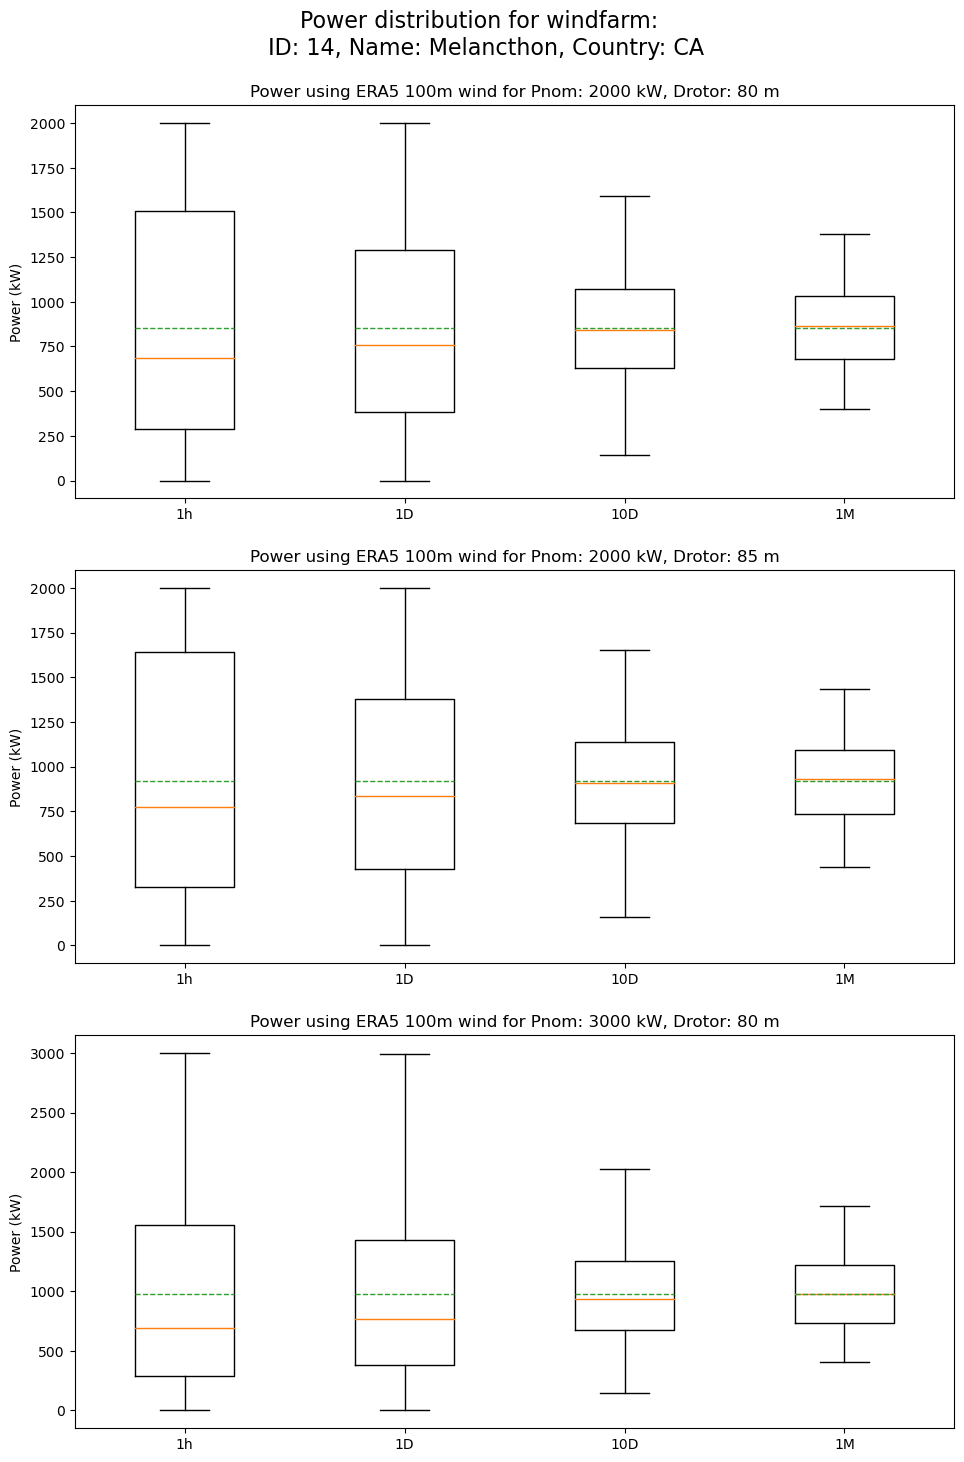

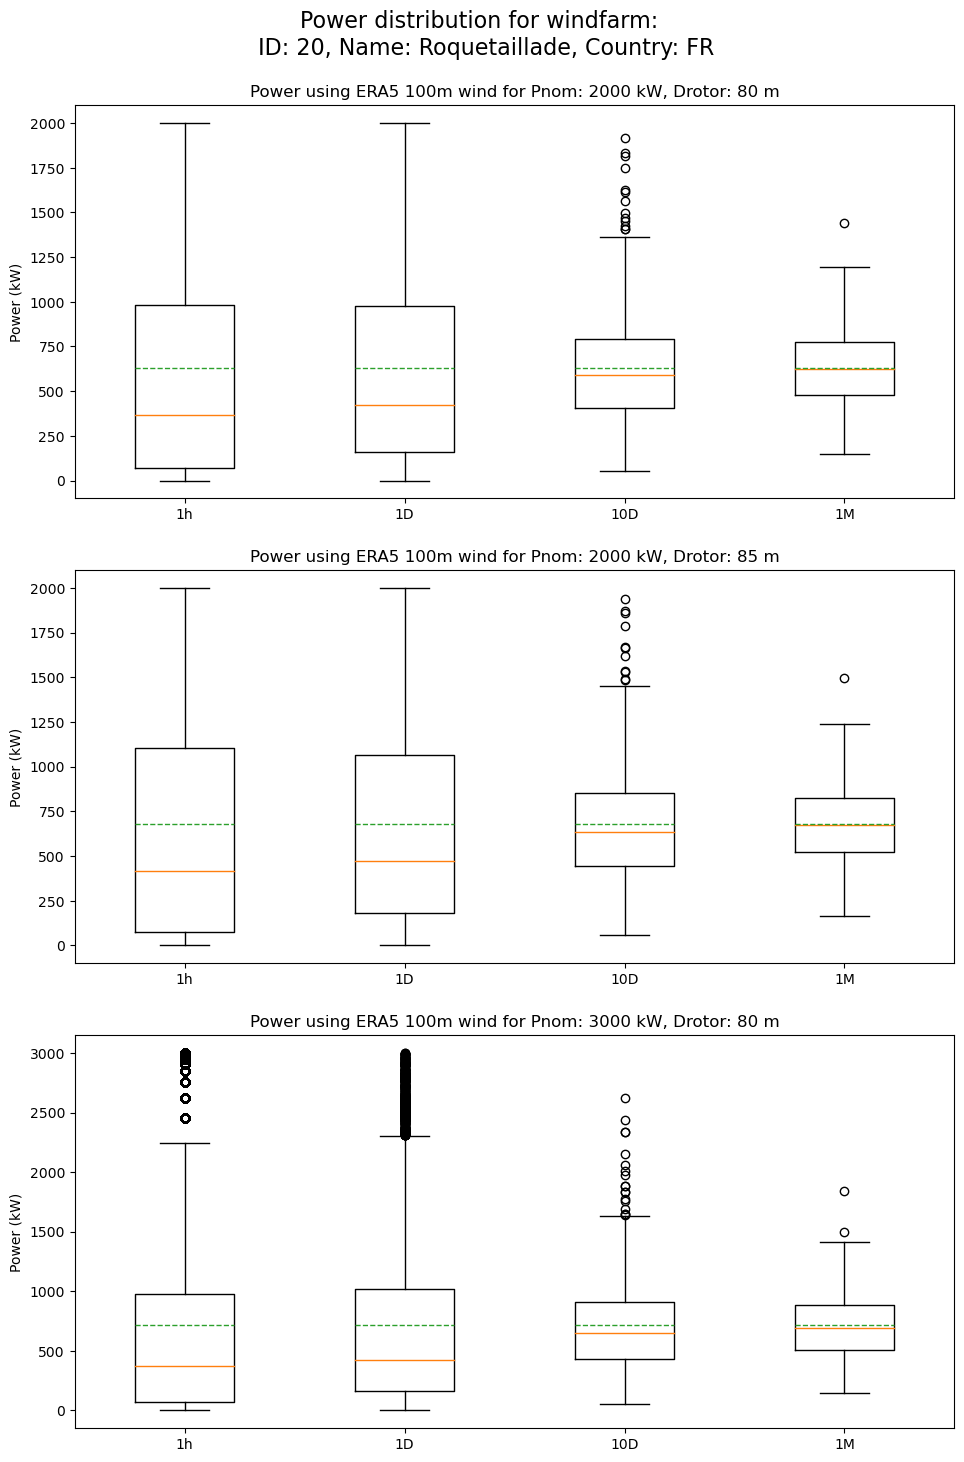

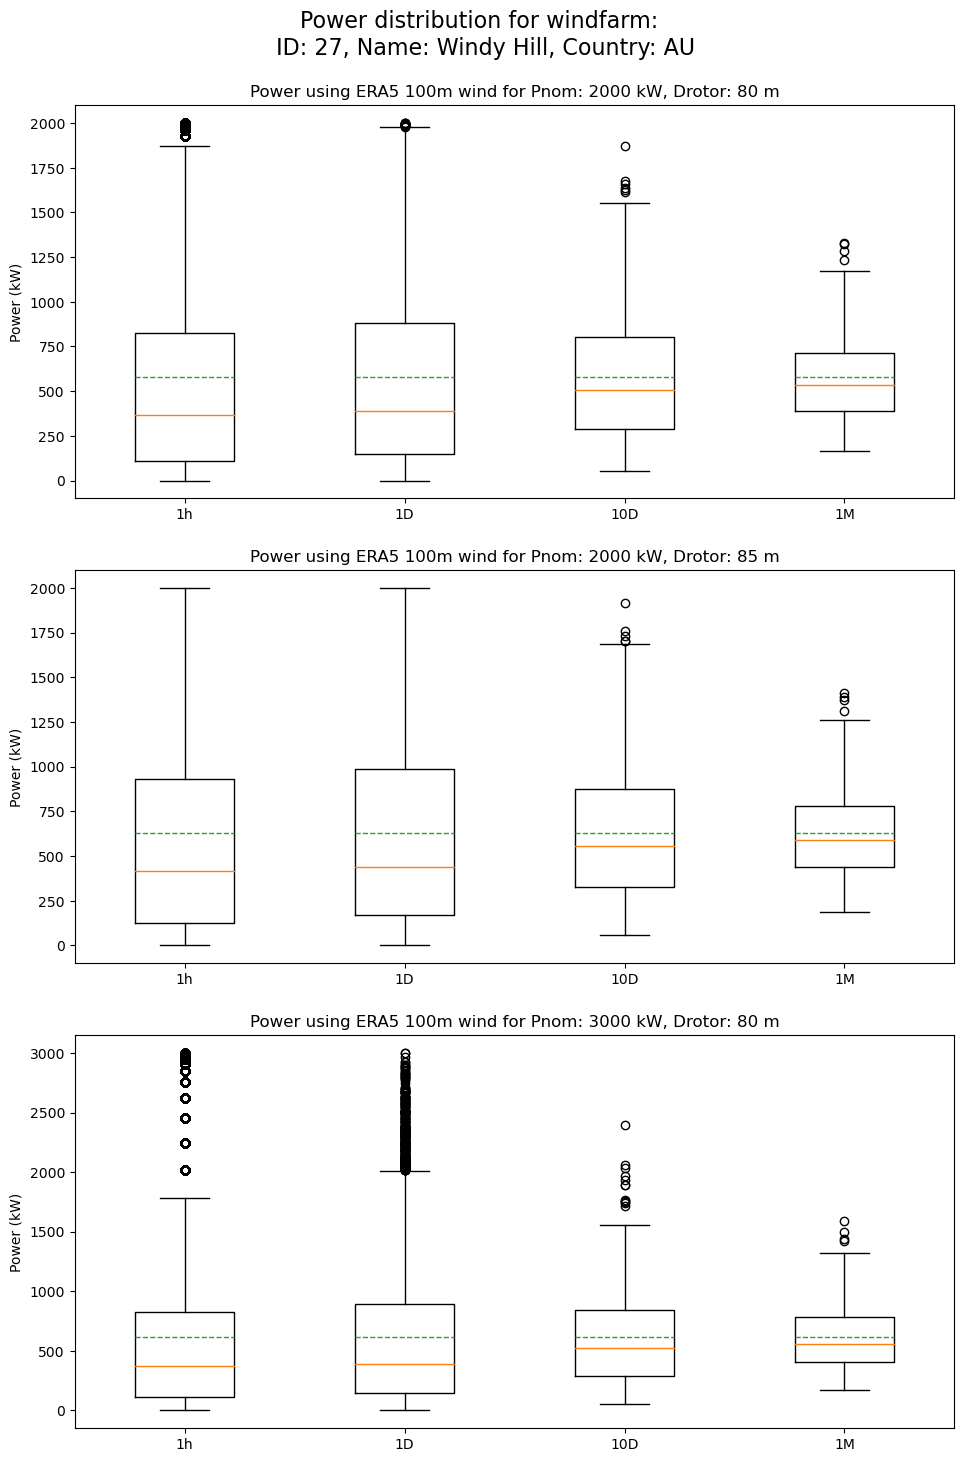

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#boxplots from power_da_list
def boxplots_from_power_da_list(power_da_list, wind_farm_id, labels):

    resampling_frequencies = [None, "1D", "10D", "1M"]

    fig, axs = plt.subplots(len(power_da_list), 1, figsize=(10, 5*len(power_da_list)))

    for i, (power_da, label) in enumerate(zip(power_da_list, labels)):
        averaged_power_da_list = [power_da] + [power_da.resample(time=freq).mean() for freq in resampling_frequencies[1:]]

        resampling_labels = ["1h", "1D", "10D", "1M"]

        axs[i].boxplot(averaged_power_da_list, labels=resampling_labels, showmeans=True, meanline=True)
        axs[i].set_title(f"Power using ERA5 100m wind for {label}")
        
        # set ylabel
        axs[i].set_ylabel("Power (kW)")

    plt.suptitle("Power distribution for windfarm: \n ID: {}, Name: {}, Country: {}".format(
        wind_farm_id, df[df["ID"] == wind_farm_id]["Name"].values[0], df[df["ID"] == wind_farm_id]["ISO code"].values[0],
    ), fontsize=16)
    plt.tight_layout(pad = 2)
    plt.show()

for wind_farm_id, power_da_list in power_da_list_collection.items():
    boxplots_from_power_da_list(power_da_list, wind_farm_id, labels)

In [21]:
quantiles_to_compute = [0, 0.05, 0.1, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9, 0.95, 1]

target_time_resolution = "1M"
intermediate_time_resolution = "1M"

def get_quantiles(power_da, quantiles_to_compute, target_time_resolution):
    averaged_power_da = power_da.resample(time=target_time_resolution).mean()
    return averaged_power_da.quantile(quantiles_to_compute, dim="time")

target_quantiles_dict = {
    wind_farm_id: get_quantiles(power_da_list[0], quantiles_to_compute, target_time_resolution)
    for wind_farm_id, power_da_list in power_da_list_collection.items()
}

target_quantiles_dict[14]

<xarray.DataArray 'power' (quantile: 11)>
array([ 397.88406372,  480.44563904,  561.07141724,  679.31777954,
        728.80011047,  863.63928223,  984.6440271 , 1029.83123779,
       1146.27718506, 1219.00521851, 1379.98571777])
Coordinates:
  * quantile  (quantile) float64 0.0 0.05 0.1 0.25 0.33 ... 0.75 0.9 0.95 1.0

In [27]:
import scipy.optimize as opt

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def distribution_match(z, *params):
    averaged_wind_intermediate, target_quantiles, kwargs_for_power, target_time_resolution = params
    Pnom, Drotor, Vcutin, Vcutoff = z
    power_curve = pc.power_curve_from_parameters(Pnom=Pnom, Drotor=Drotor, Vcutin=Vcutin, Vcutoff=Vcutoff, **kwargs_for_power)
    power_da = power_curve(averaged_wind_intermediate).resample(time=target_time_resolution).mean()
    quantiles = power_da.quantile(quantiles_to_compute, dim="time")
    return rmse(quantiles, target_quantiles).values

optim_result_dict = dict()
kwargs_for_power = dict()

starting_point = (
    power_conversion_function_parameters[0]["Pnom"],  # Pnom
    power_conversion_function_parameters[0]["Drotor"],  # Drotor
    3,  # Vcutin
    25  # Vcutoff
)

bounds = (
    (1000, 5000),  # Pnom
    (50, 120),  # Drotor
    (0, 10),  # Vcutin
    (5, 30)  # Vcutoff
)

for wind_farm_id, power_da_list in power_da_list_collection.items():
    averaged_wind_intermediate = wind_farm_ds_dict[wind_farm_id].resample(time=intermediate_time_resolution).mean()
    params = (averaged_wind_intermediate, target_quantiles_dict[wind_farm_id], kwargs_for_power, target_time_resolution)

    resminimize = opt.minimize(
        distribution_match, x0=starting_point,
        args=params,
        bounds=bounds,
        method="Nelder-Mead",
        options={"maxiter": 1000, "disp": True}
    )

    optim_result_dict[wind_farm_id] = resminimize.x
    print(resminimize)

# averaged_wind_1m = ds.ws100.resample(time="1M").mean()
# params = (averaged_wind_1m, quantiles, kwargs_for_power)

# resbrute = opt.brute(
#     distribution_match,
#     ranges=(slice(1800, 2200, 50), slice(75, 95, 5), slice(0, 6, 0.5), slice(15, 30, 1)),
#     # ranges=(slice(2000, 2200, 100), slice(75, 85, 5), slice(0, 1, 1), slice(20, 21, 1)),
#     args=params,
#     finish=None,
#     # workers=4
# )


Optimization terminated successfully.
         Current function value: 63.910760
         Iterations: 109
         Function evaluations: 257
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 63.91076033274625
             x: [ 1.288e+03  8.854e+01  2.972e+00  2.593e+01]
           nit: 109
          nfev: 257
 final_simplex: (array([[ 1.288e+03,  8.854e+01,  2.972e+00,  2.593e+01],
                       [ 1.288e+03,  8.854e+01,  2.972e+00,  2.593e+01],
                       ...,
                       [ 1.288e+03,  8.854e+01,  2.972e+00,  2.593e+01],
                       [ 1.288e+03,  8.854e+01,  2.972e+00,  2.593e+01]]), array([ 6.391e+01,  6.391e+01,  6.391e+01,  6.391e+01,
                        6.391e+01]))
Optimization terminated successfully.
         Current function value: 60.415293
         Iterations: 136
         Function evaluations: 338
       message: Optimization terminated successfully.
       success: True

Here is a comparison of the two distributions

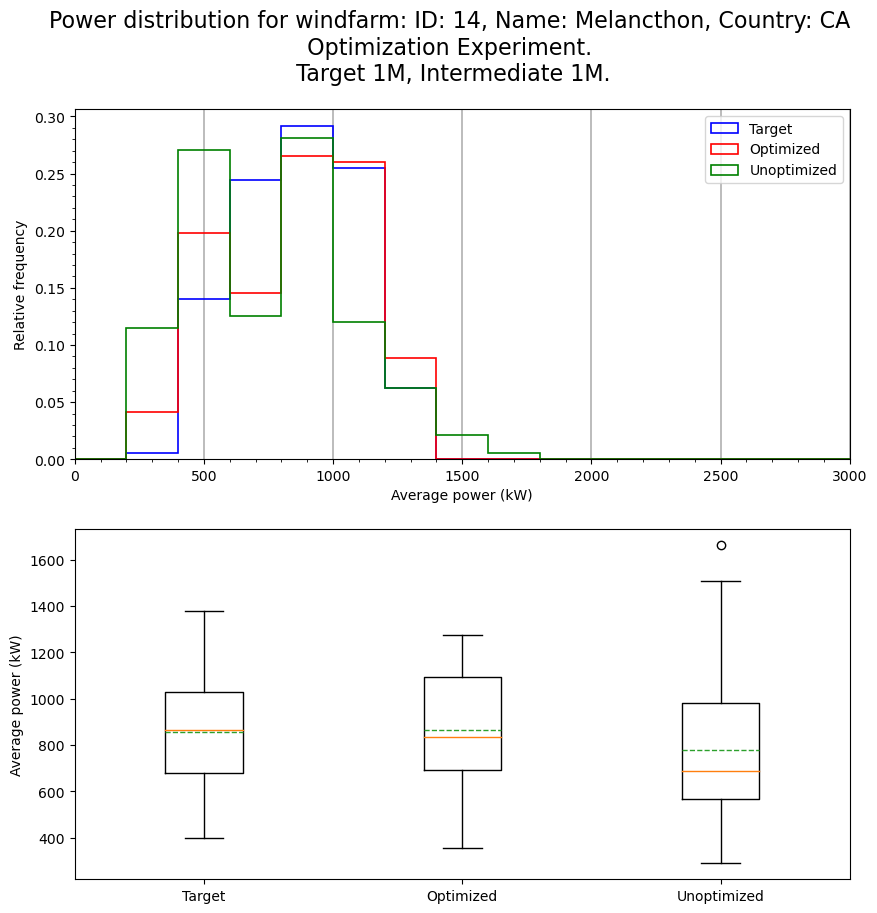

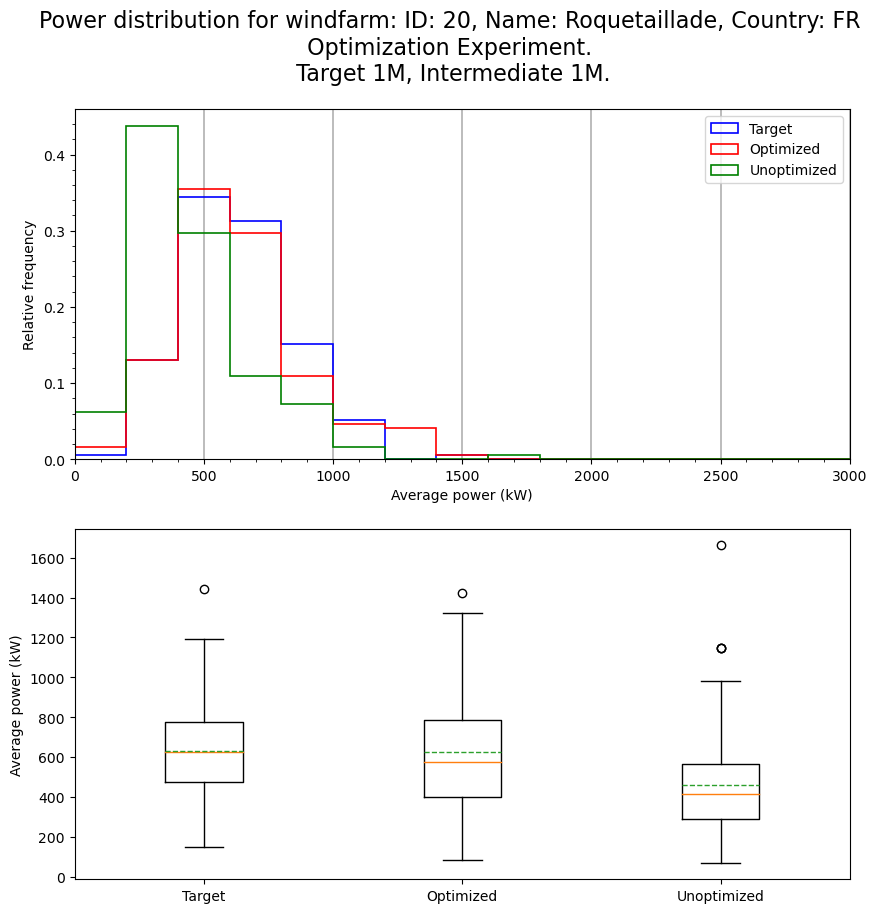

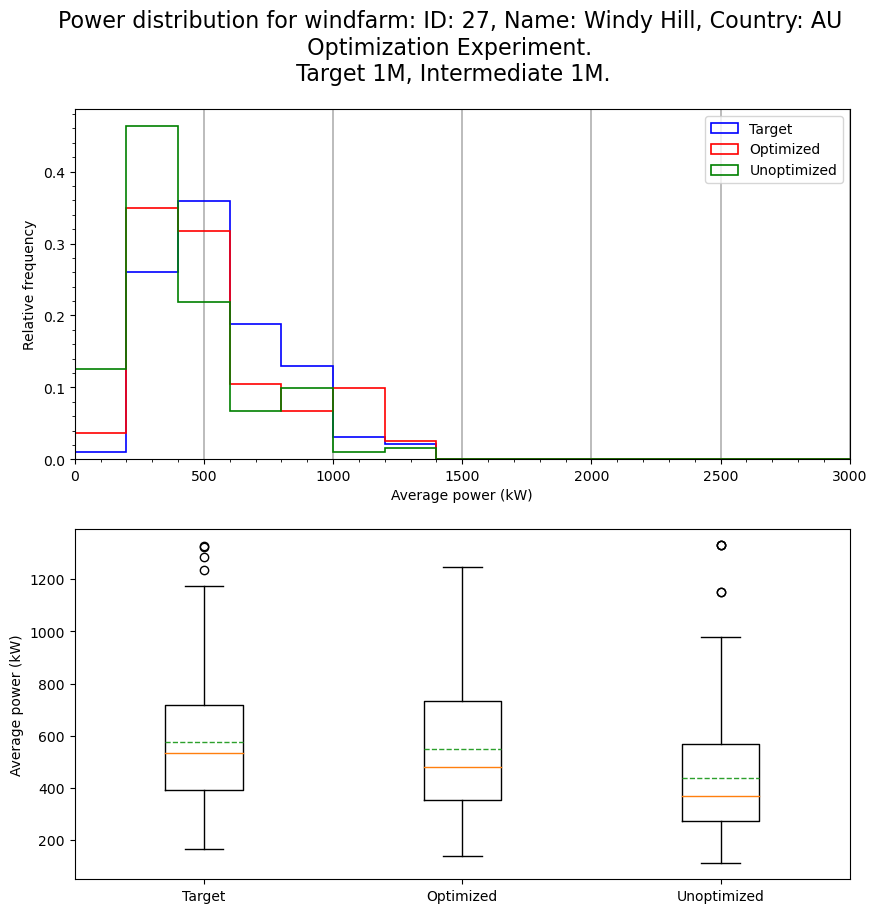

In [25]:
def plot_hist_and_boxplot(resminimize, averaged_wind_intermediate, power_da_target_tres, wind_farm_id):
    Pnom, Drotor, Vcutin, Vcutoff = resminimize
    optimized_conversion_function = pc.power_curve_from_parameters(Pnom=Pnom, Drotor=Drotor, Vcutin=Vcutin, Vcutoff=Vcutoff)

    power_da_optimized = optimized_conversion_function(averaged_wind_intermediate)
    power_da_optimized_target_tres = power_da_optimized.resample(time=target_time_resolution).mean()

    power_da_unoptimized = power_conversion_functions[0](averaged_wind_intermediate)
    power_da_unoptimized_target_tres = power_da_unoptimized.resample(time=target_time_resolution).mean()


    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    labels_histogram = ["Target", "Optimized", "Unoptimized"]

    colors = ["blue", "red", "green"]

    bins = np.arange(0, 3200, 200)

    # plot the histograms
    for color, label, power_da_resampled in zip(
        colors, labels_histogram, (power_da_target_tres, power_da_optimized_target_tres, power_da_unoptimized_target_tres)):
        weights = np.ones_like(power_da_resampled) / len(power_da_resampled)
        n, bins, patches = axs[0].hist(power_da_resampled, bins=bins, weights=weights,
                                        edgecolor=color, linewidth=1.2,
                                        density=False, facecolor="none",
                                        histtype="step", label=label)
    
    axs[0].set_xlim(0, 3000)
    axs[0].set_ylim(0, axs[0].get_ylim()[1] / sum(n))

    axs[0].set_axisbelow(True)
    axs[0].grid(axis="x", linestyle="-", linewidth=1.2)
    axs[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    axs[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    axs[0].set_xlabel('Average power (kW)')
    axs[0].set_ylabel('Relative frequency')

    # use legend
    axs[0].legend(loc="upper right")

    # plot the boxplots
    axs[1].boxplot([power_da_target_tres, power_da_optimized_target_tres, power_da_unoptimized_target_tres], labels=labels_histogram,
                    showmeans=True, meanline=True)
    axs[1].set_ylabel('Average power (kW)')

    # set the title of the figure
    fig.suptitle("Power distribution for windfarm: ID: {}, Name: {}, Country: {}\n Optimization Experiment. \n Target {}, Intermediate {}.".format(
        wind_farm_id, df[df["ID"] == wind_farm_id]["Name"].values[0], df[df["ID"] == wind_farm_id]["ISO code"].values[0],
        target_time_resolution, intermediate_time_resolution
    ), fontsize=16)
    plt.show()

for wind_farm_id, power_da_list in power_da_list_collection.items():
    averaged_wind_intermediate = wind_farm_ds_dict[wind_farm_id].resample(time=intermediate_time_resolution).mean()
    power_da_target_tres = power_da_list[0].resample(time=target_time_resolution).mean()
    plot_hist_and_boxplot(optim_result_dict[wind_farm_id], averaged_wind_intermediate, power_da_target_tres, wind_farm_id)